In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()

plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('pjme_hourly.csv')
# set our dataframe to datetime
df = df.set_index('Datetime')
# to cast the object of our dataframe as a datetime
df.index = pd.to_datetime(df.index)

In [3]:
df.head(3)

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0


In [4]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


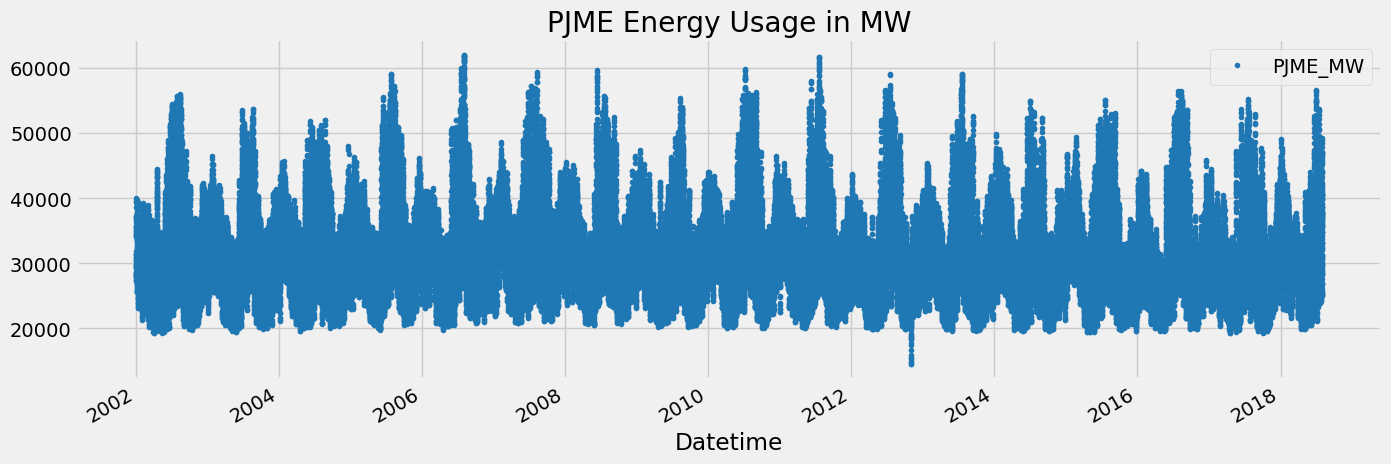

In [5]:
df.plot(style=".", figsize=(15, 5), color=color_pal[0], title="PJME Energy Usage in MW")

plt.show()


### Train/test Split

In [6]:
# Our training dataset will be from january 2012 to december 2014
# our test dataset will be from january 2015
train = df.loc[df.index < '01-02-2015']
test = df.loc[df.index >= '01-02-2015']

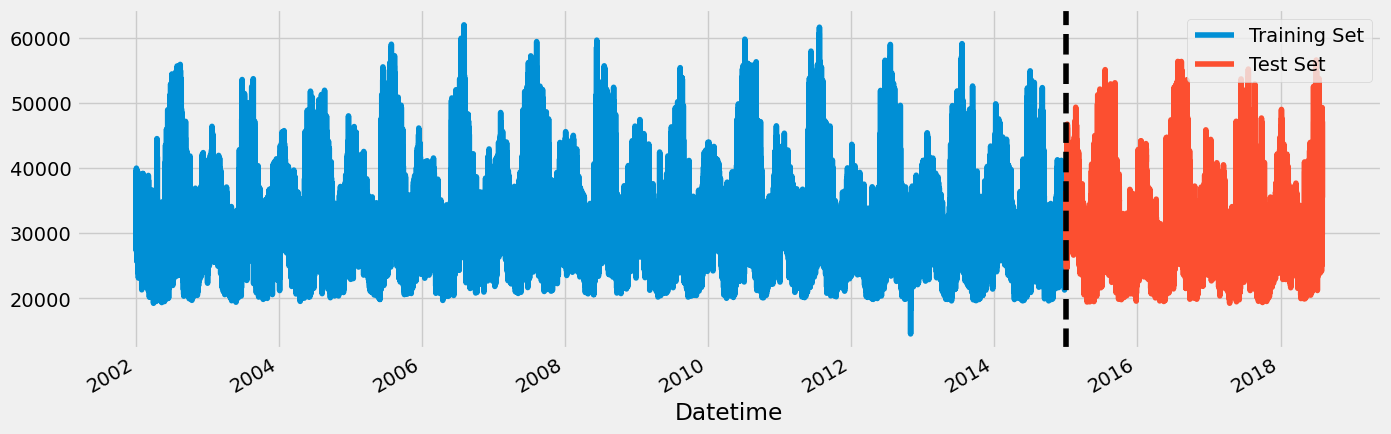

In [7]:
#plotting both test and training dataset
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls= '--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

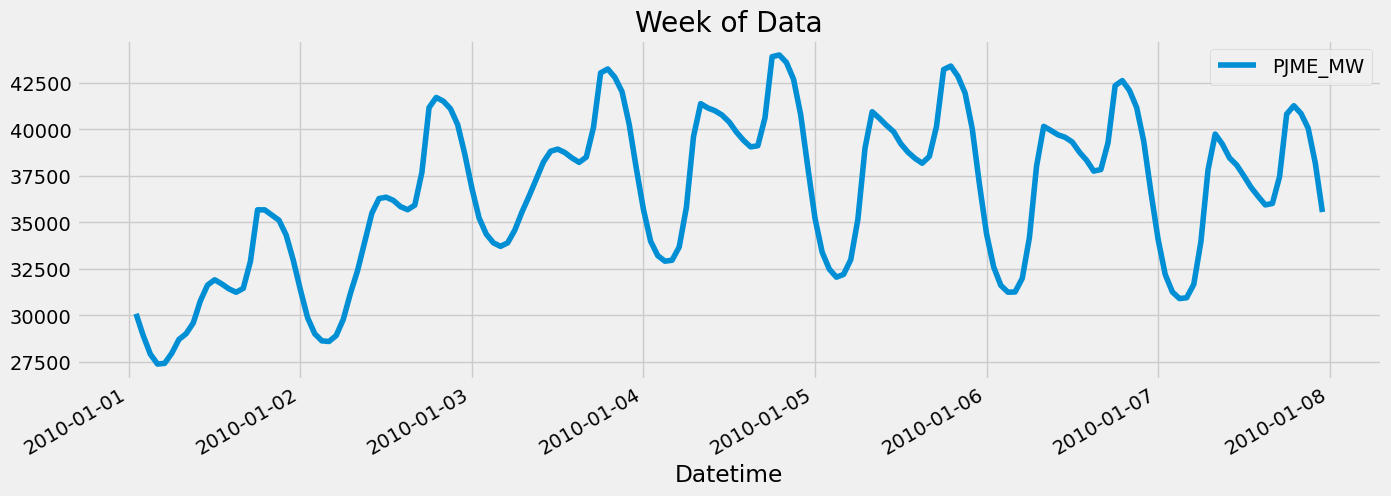

In [8]:
# Plotting one single week
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15, 5), title='Week of Data')


### Feature Engineering

In [9]:
def create_features(df):
    '''Create features 
      datetime column'''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df



In [10]:
df = create_features(df)

### Visualize our Feature/target relationship

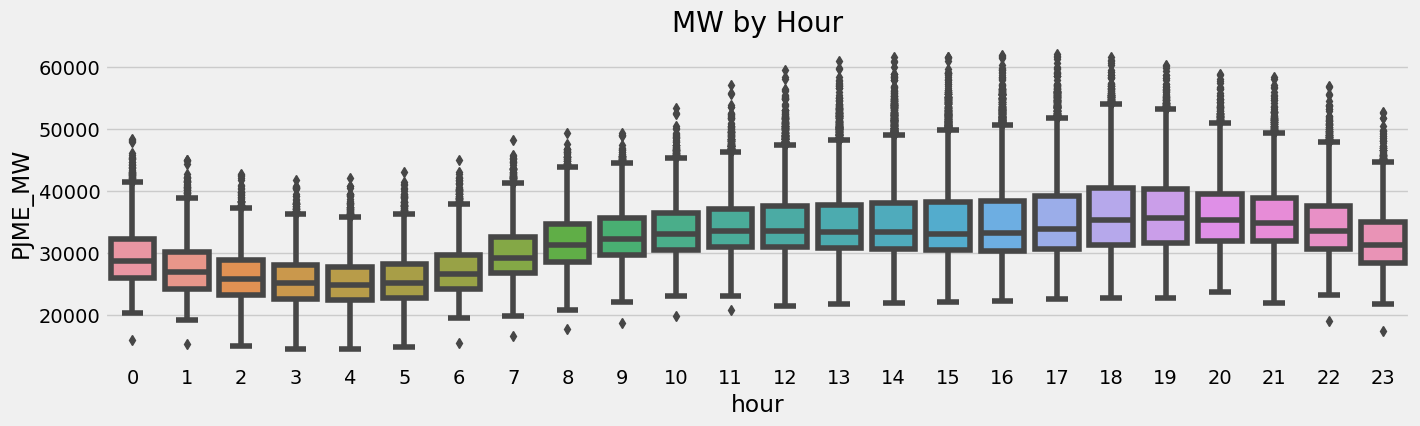

In [11]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

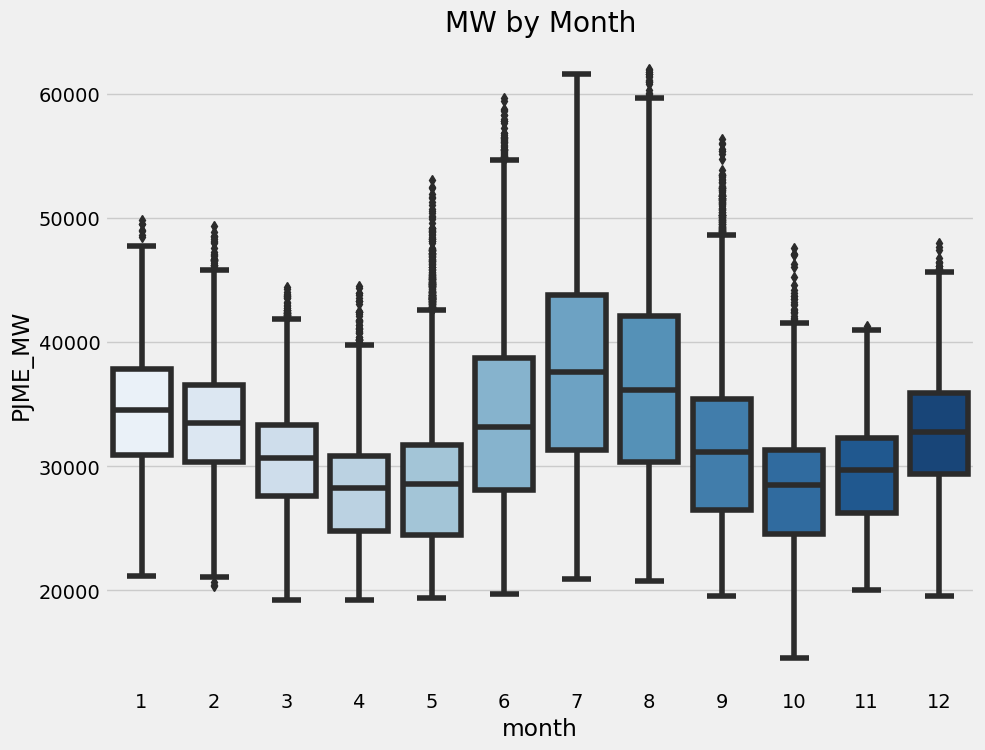

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

### Model Creation

In [13]:
train = create_features(train)
test = create_features(test)

In [14]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'month', 'quarter', 'year',
       'dayofyear'],
      dtype='object')

In [15]:
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'



In [16]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32601.64883	validation_1-rmse:31654.44852
[100]	validation_0-rmse:12341.97851	validation_1-rmse:11519.29646
[200]	validation_0-rmse:5374.10875	validation_1-rmse:5166.27491
[300]	validation_0-rmse:3376.01748	validation_1-rmse:3836.69121
[400]	validation_0-rmse:2883.40136	validation_1-rmse:3720.54848
[439]	validation_0-rmse:2794.33241	validation_1-rmse:3731.26475


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Feature importance

In [18]:
reg.feature_importances_

array([0.08895111, 0.37291634, 0.13817325, 0.0232741 , 0.3581776 ,
       0.01850757], dtype=float32)

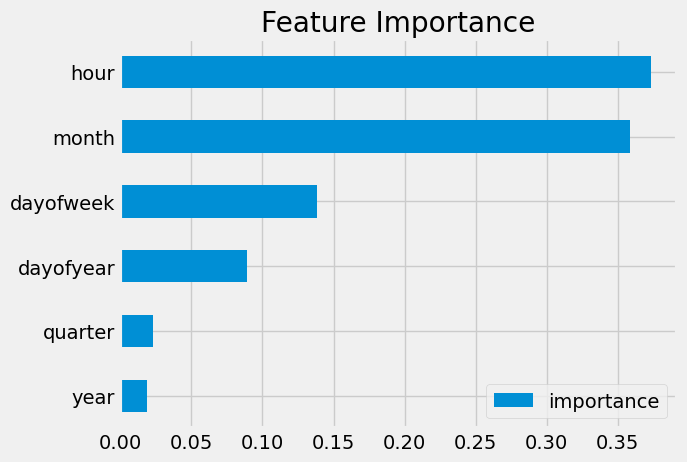

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forcast on Test

In [20]:
test['prediction'] = reg.predict(X_test)

In [21]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df.head()

,PJME_MW,hour,dayofweek,month,quarter,year,dayofyear,prediction
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,NaN


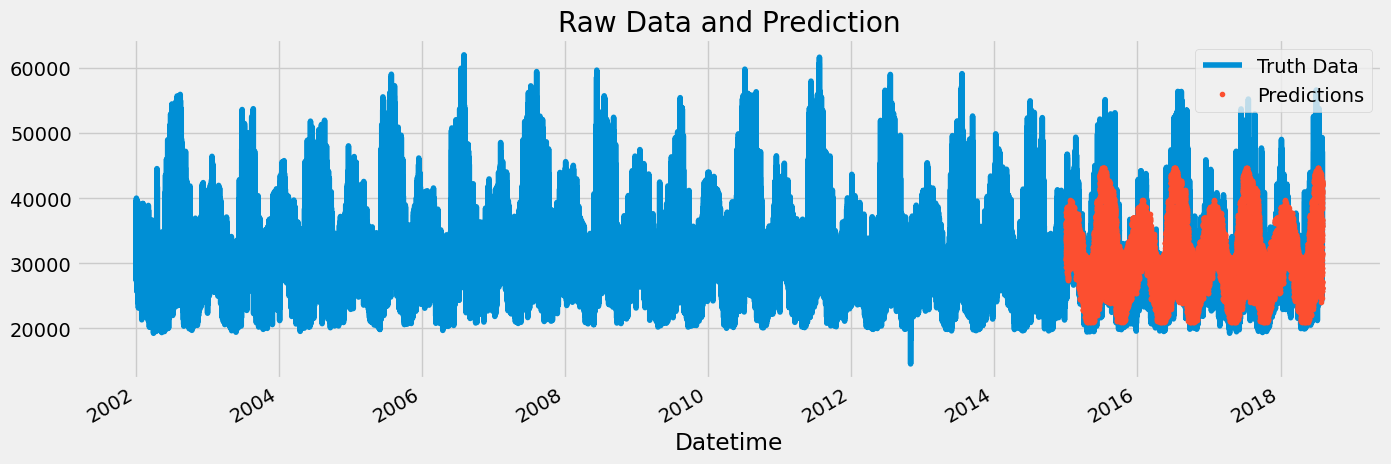

In [22]:

ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

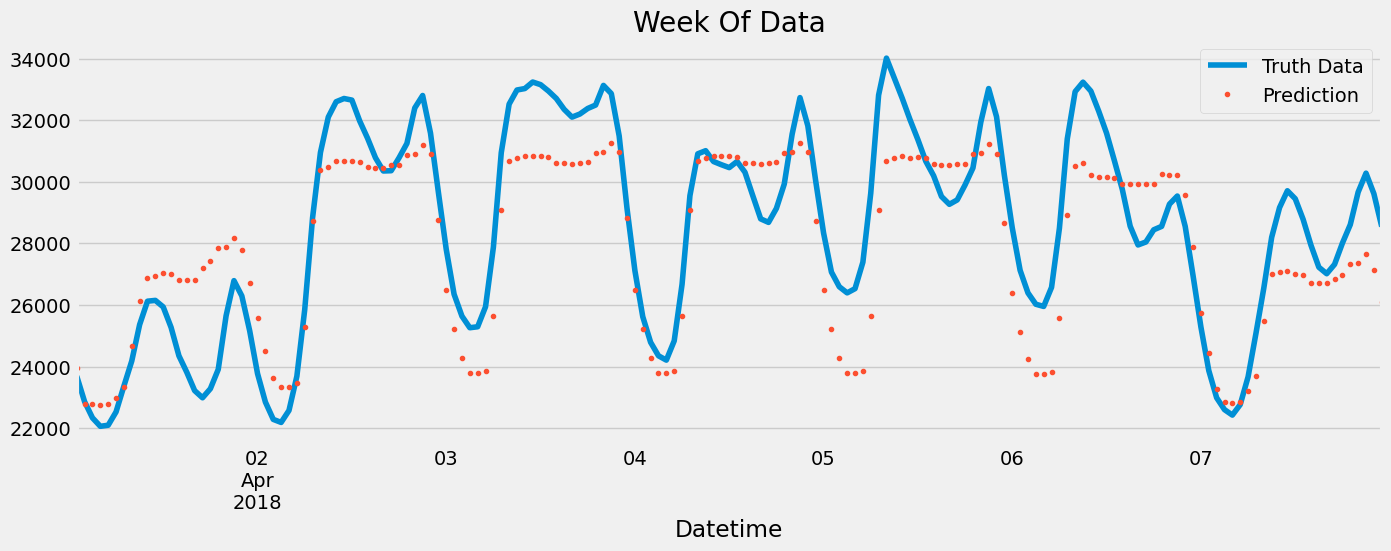

In [23]:
#plotting the predictions over 1 week
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [25]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3719.09


### Calculate error
- Look at the worst and best predicted days

In [26]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [28]:
test['date'] = test.index.date

In [29]:
# average reeor for each predicted day
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    14492.957031
2016-08-14    14340.778564
2016-09-10    12559.538086
2016-08-12    11510.624268
2016-09-09    11509.444336
2015-02-20    10906.198649
2018-01-06    10905.805664
2016-08-11    10359.460042
2018-01-07    10266.644613
2017-05-19    10240.479085
Name: error, dtype: float64

- The worst predicted days all seem to be at the end of august 2016, 13tgh and 14th of August 2016.


In [30]:
# average error for each predicted day
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2016-09-27    343.159587
2016-04-04    429.718099
2015-03-10    444.035482
2016-05-01    453.699056
2016-12-08    491.743896
2015-10-28    505.597412
2015-09-25    512.259928
2017-06-16    517.454834
2018-05-17    533.002523
2017-05-02    537.138346
Name: error, dtype: float64

- The best predicted days are in september 27th 2016, April 4th 2016 and march 10 2015